# A straight waveguide
For our first example, let's examine the field pattern excited by a localized continuous wave (CW) source in a waveguide — first straight, then bent. The waveguide will have frequency-independent $\epsilon$=12 and width 1 $\mu$m. The unit length in this example is 1 $\mu$m. See also Units.

The first thing to do always is to load the Meep library, along with any other library we may need for post processing or visualization:

In [1]:
import meep as mp
from meep.materials import fused_quartz #using this makes the sim unstable for some reason.
import numpy as np

In [19]:
cell = mp.Vector3(85,90,0) # in microns

Gap = 6.434e-01
wgYpos = -40-Gap-0.5

WaveGuide = mp.Block(mp.Vector3(mp.inf,1,mp.inf),
                     center=mp.Vector3(y=wgYpos),
                     material=mp.Medium(index=1.440))

Circle = mp.Cylinder(radius=40, material=mp.Medium(index=1.440))


WGFilm1 = mp.Block(mp.Vector3(10,0.05,mp.inf),
                     center=mp.Vector3(y=wgYpos+0.5+0.025),
                     material=mp.Medium(index=2.5))

WGFilm2 = mp.Block(mp.Vector3(10,0.05,mp.inf),
                     center=mp.Vector3(y=wgYpos-0.50-0.025),
                     material=mp.Medium(index=2.5))



geometry = [WaveGuide,Circle,WGFilm1,WGFilm2]


fsrc = 1/1.5475 # frequency of eigenmode or constant-amplitude source
df = 16e-3

kx = 0.4    # initial guess for wavevector in x-direction of eigenmode
kpoint = mp.Vector3(kx)

bnum = 1    # band number of eigenmode

sources = [mp.EigenModeSource(src=mp.GaussianSource(fsrc,fwidth=df),
                                  center=mp.Vector3(x=-40,y=wgYpos),
                                  size=mp.Vector3(y=4),
                                  direction=mp.NO_DIRECTION,
                                  eig_kpoint=kpoint,
                                  eig_band=bnum,
                                  eig_parity=mp.EVEN_Y+mp.ODD_Z,
                                  eig_match_freq=True)]


pml_layers = [mp.PML(1.0)]


resolution = 20 #pixels per distance unit, so 10 px/um rn. (ideal)

sim = mp.Simulation(cell_size=cell,
                    eps_averaging=True,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    split_chunks_evenly=False
                    #Courant=0.99
                    )



nfreq = 2000  # number of frequencies at which to compute flux

# reflected flux
src_fr = mp.FluxRegion(center=mp.Vector3(-35,wgYpos,0), size=mp.Vector3(0,4,0))                            
src = sim.add_flux(fsrc, 8e-3, nfreq, src_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(40,wgYpos,0), size=mp.Vector3(0,4,0))
tran = sim.add_flux(fsrc, 8e-3, nfreq, tran_fr)

# Sphere flux

sphere_fr = mp.FluxRegion(center=mp.Vector3(0,36,0), size=mp.Vector3(0,10,0))
sphereMode = sim.add_flux(fsrc, 8e-3, nfreq, sphere_fr)



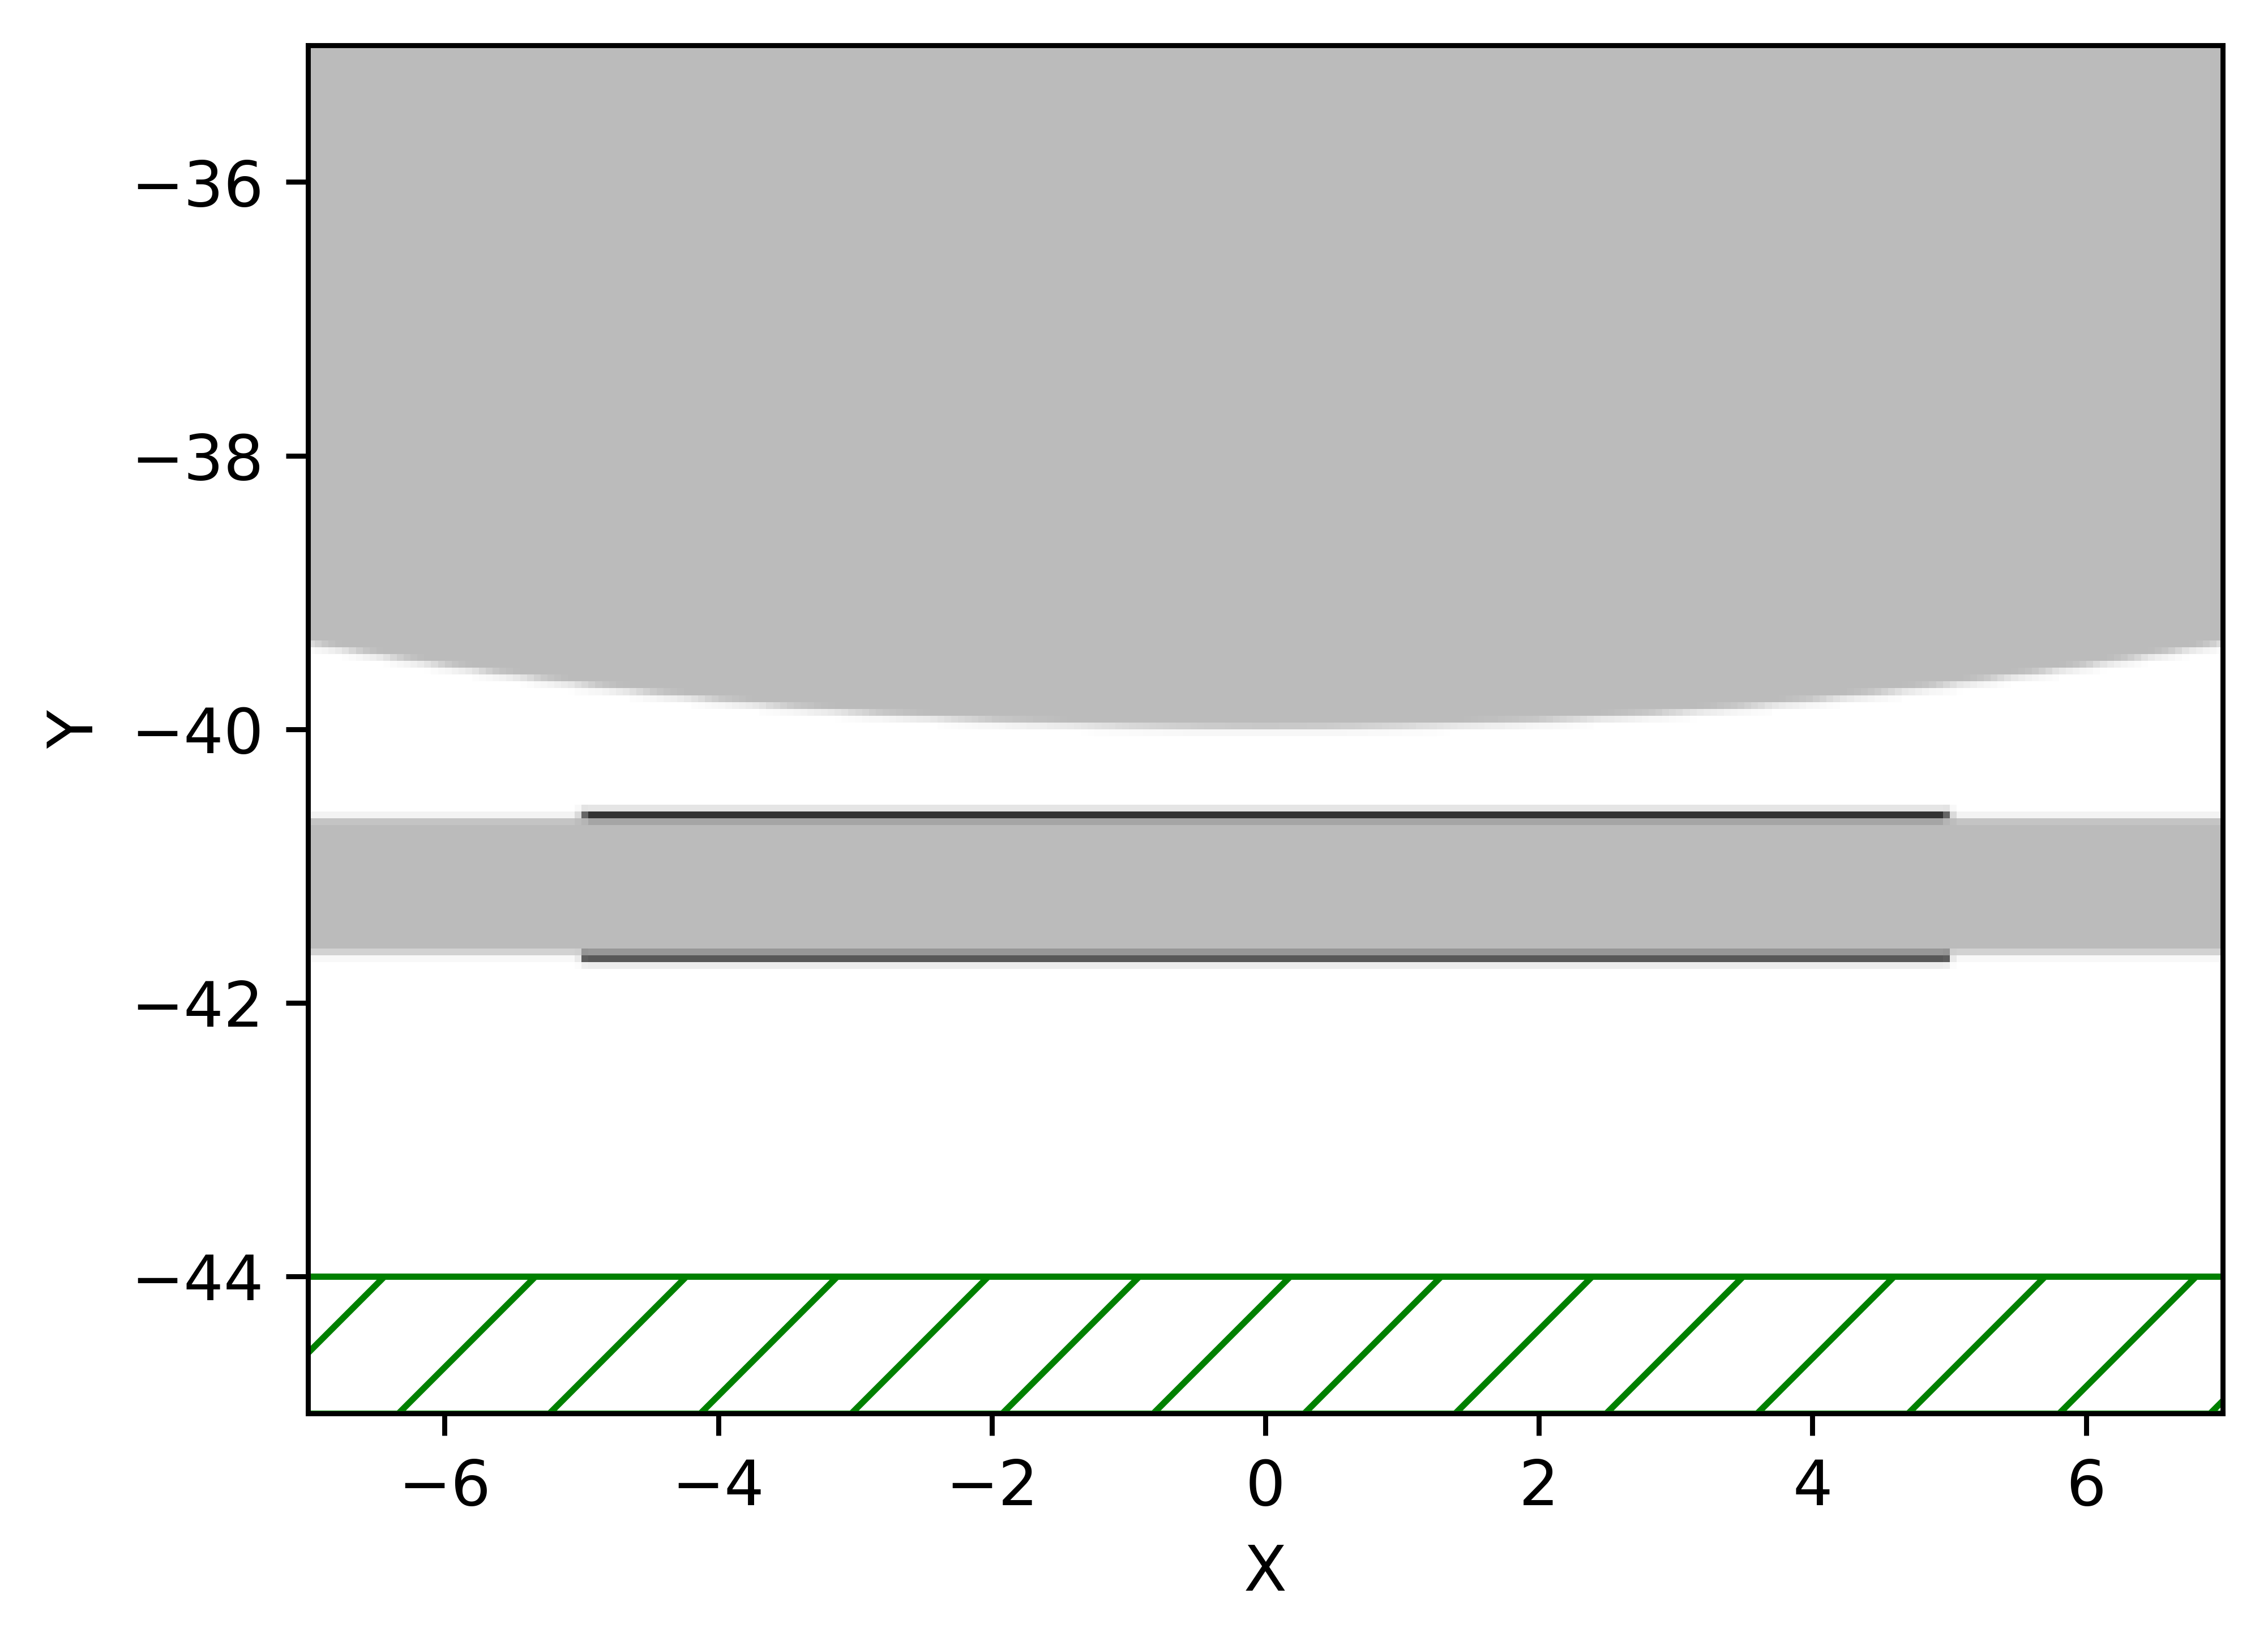

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(dpi=800)
sim.plot2D(eps_parameters={'alpha':0.8, 'interpolation':'none'})
plt.xlim(-7,7)
plt.ylim(-45,-35)
plt.show()

In [22]:
sim.run(until=100)

FloatProgress(value=0.0, description='0% done ')

Meep progress: 4.675/100.0 = 4.7% done in 4.0s, 81.8s to go
on time step 187 (time=4.675), 0.0214363 s/step
Meep progress: 9.625/100.0 = 9.6% done in 8.0s, 75.2s to go
on time step 386 (time=9.65), 0.020201 s/step
Meep progress: 14.25/100.0 = 14.2% done in 12.0s, 72.4s to go
on time step 571 (time=14.275), 0.0217199 s/step
Meep progress: 18.95/100.0 = 18.9% done in 16.0s, 68.6s to go
on time step 759 (time=18.975), 0.0212958 s/step
Meep progress: 23.625/100.0 = 23.6% done in 20.0s, 64.8s to go
on time step 946 (time=23.65), 0.0214775 s/step
Meep progress: 27.35/100.0 = 27.4% done in 24.1s, 63.9s to go
on time step 1095 (time=27.375), 0.0270105 s/step
Meep progress: 30.075000000000003/100.0 = 30.1% done in 28.1s, 65.3s to go
on time step 1204 (time=30.1), 0.0369792 s/step
Meep progress: 34.25/100.0 = 34.2% done in 32.1s, 61.6s to go
on time step 1372 (time=34.3), 0.0238708 s/step
Meep progress: 39.150000000000006/100.0 = 39.2% done in 36.1s, 56.1s to go
on time step 1568 (time=39.2), 0.

In [10]:
Data = {}
Data['WGM_mode'] = {}
Data['Trans'] = {}

Data['WGM_mode']['yPos'] = sim.get_array_metadata(center=mp.Vector3(0,36,0), size=mp.Vector3(0,10,0))[1]
Data['WGM_mode']['lambda'] = 1/np.array(mp.get_flux_freqs(sphereMode))

matrix = np.zeros([len(sim.get_dft_array(sphereMode,mp.Ez,0)),nfreq],dtype=np.complex128)
for i in range(0,nfreq):
    matrix[:,i] = sim.get_dft_array(sphereMode,mp.Ez,i)

Data['WGM_mode']['matrix'] = matrix
    
Data['Trans']['lambda'] = np.array(mp.get_flux_freqs(tran))


Source = np.array(mp.get_fluxes(src))
Out = np.array(mp.get_fluxes(tran))

Tran = Out/Source

Data['Trans']['RelFlux'] = Tran



In [6]:

flux_freqs = np.array(mp.get_flux_freqs(tran))
Source = np.array(mp.get_fluxes(src))
Out = np.array(mp.get_fluxes(tran))

Tran = Out/Source

In [7]:
import matplotlib.pyplot as plt
from functions import fig_format


In [1]:
fig,axes = plt.subplots(2,1,figsize=(16,16))

minWL = min(Data['WGM_mode']['lambda'])
maxWL = max(Data['WGM_mode']['lambda'])
minY = min(Data['WGM_mode']['yPos'])
maxY = max(Data['WGM_mode']['yPos'])

pos = axes[0].imshow(np.fliplr(np.flipud(np.absolute(matrix))), interpolation='nearest', aspect='auto',extent=(minWL, maxWL,minY,maxY),vmin=0, vmax=50)


axes[1].plot(1/flux_freqs,Tran,label='Overall Transmission')

axes[1].set_xlim(minWL,maxWL)

fig_format(axes[0],'Bare WGM, 10ps run','','Y-Position/ um','')

fig_format(axes[1],'','Wavelength / um','Relative Power','')


NameError: name 'plt' is not defined